In [2]:
import pandas as pd
import os
from tqdm import tqdm
import pydicom
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
import segmentation_models_pytorch as smp
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, DataLoader

/home/abk171/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_excel('/data_vault/hexai02/CarpalTunnel/AI Project Data Clean 10-8.xlsx')

In [4]:
df.head(100)

,Number,WristImage Segmentation for AI Analysis,Arm (L/R),Sex,Race,Ethnicity,Age,Clinical Signs of CTS,CTS-6 Score,Measurement at Wrist
0,21,Yes,R,M,White,Non-Hispanic,43.0,Y,12.5,12.16
1,22,Yes,R,M,White,Unreported/Chose not to disclose,74.0,Y,16.5,20.10
2,23,Yes,L,M,White,Unreported/Chose not to disclose,74.0,Y,11.5,13.83
3,24,Yes,R,F,Black,Non-Hispanic,63.0,Y,21.0,16.55
4,25,Yes,R,M,White,Non-Hispanic,49.0,Y,9.0,19.21
...,...,...,...,...,...,...,...,...,...,...
95,163,Yes,R,F,White,Non-Hispanic,74.0,?,NaN,12.78
96,164,Yes,R,F,Black,Non-Hispanic,67.0,N,3.5,7.57
97,165,yes,R,F,White,Non-Hispanic,65.0,N,0.0,16.10
98,166,Yes,L,F,White,Non-Hispanic,51.0,Y,16.5,9.95


In [5]:
df['Clinical Signs of CTS'].unique()

array(['Y', 'N', 'Yes', '?'], dtype=object)

In [6]:
df['Clinical Signs of CTS'] = df['Clinical Signs of CTS'].replace('Yes', 'Y')

In [7]:
df['Clinical Signs of CTS'].unique()

array(['Y', 'N', '?'], dtype=object)

In [7]:
count_question_mark = (df['Clinical Signs of CTS'] == '?').sum()
print(count_question_mark)

1


In [8]:
df = df[df['Clinical Signs of CTS'] != '?']

In [23]:
df['Number'] = df['Number'].astype(str)

In [9]:
restructured_root = 'data_yolo'
image_dir = os.path.join(restructured_root, 'images')
image_train_dir = os.path.join(image_dir, 'train')
image_val_dir = os.path.join(image_dir, 'val')
image_test_dir = os.path.join(image_dir, 'test')
label_dir = os.path.join(restructured_root, 'labels')
label_train_dir = os.path.join(label_dir, 'train')
label_val_dir = os.path.join(label_dir, 'val')

In [10]:
anno_dir = '/data_vault/hexai02/CarpalTunnel/Annotations'
dicom_dir = '/data_vault/hexai02/CarpalTunnel/Images'

In [11]:
def load_mask(mask_path):
    mask = sitk.ReadImage(mask_path)
    return sitk.GetArrayFromImage(mask)[0][: 450, 200: 1300]

def load_dicom(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    return dicom_data.pixel_array[: 450, 200: 1300]

In [ ]:
model = YOLO("runs/detect/train17/weights/best.pt")
model.eval()

In [13]:
config = {
    'epochs': 40,
    'in_channels': 1,
    'dropout': 0.2,
    'decoder_attention_type': 'scse',
    'init_lr': 5e-4,
    'weight_decay': 0.05,
    'T_max': 10,
    'eta_min': 3e-5
}

In [14]:
def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    return model, optimizer, scheduler, epoch

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

unet_model = smp.Unet(encoder_name="resnet18",in_channels=1,dropout=config['in_channels'],decoder_attention_type=config['decoder_attention_type']).to(device)

# unet_model, _, _, _ = load_model(unet_model, optimizer=None, scheduler=None, path=f'unet_runs/epoch_40.pth')
checkpoint = torch.load('unet_runs/epoch_40.pth', map_location="cuda")
unet_model.load_state_dict(checkpoint, strict=True)
unet_model.eval()

In [16]:
df.columns

Index(['Number', 'WristImage Segmentation for AI Analysis', 'Arm (L/R)', 'Sex',
       'Race', 'Ethnicity', 'Age', 'Clinical Signs of CTS', 'CTS-6 Score',
       'Measurement at Wrist'],
      dtype='object')

In [124]:
train_images = []
train_labels = []
val_images = []
val_labels = []


image_transform = T.Compose([
    T.Resize((512, 512), interpolation=T.InterpolationMode.BILINEAR),  # ✅ Resize first
    T.Normalize(mean=[0.5], std=[0.5]),  # ✅ Normalize after
])

def fill_arr(img_dir, img_bucket, mask_bucket):
    for jpg_name in tqdm(os.listdir(img_dir)): 
        entry_name = jpg_name.split('.')[0]
        img_filename = entry_name + '.dcm'

        # df['Clinical Signs of CTS'].unique()
        clinical_signs = df.loc[df['Number'] == entry_name, 'Clinical Signs of CTS'].values
        if len(clinical_signs) == 0:
            print(f"{entry_name}")
            continue
        classification_tensor = torch.tensor([1 if clinical_signs[0] == 'Y' else 0], dtype=torch.uint8)
        
        # Load DICOM image
        img = load_dicom(os.path.join(dicom_dir, img_filename))

        # Get bounding box from YOLO
        result = model(img, save=False, verbose=False)
        box = result[0].boxes
        
        if len(box.xyxy.tolist()) == 0:
            continue  
        mask_bucket.append(classification_tensor)

        x1, y1, x2, y2 = map(int, box.xyxy.tolist()[0])
        img_slice = img[y1:y2, x1:x2, 0]  # Crop the region


        img_tensor = torch.from_numpy(img_slice).float()  # Convert to float


        img_tensor = img_tensor / 255.0  


        if img_tensor.dim() == 2:
            img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)  # Convert (H, W) → (1, H, W)


        img_tensor = image_transform(img_tensor)  
        

        img_tensor = img_tensor.to(device)


        with torch.no_grad():
            mask_gpu = unet_model(img_tensor)  
        

        img_resized = img_tensor.squeeze().cpu().detach().numpy()  
        mask = mask_gpu.squeeze().cpu().detach().numpy()  


        img_2channel = np.stack((img_resized, mask), axis=0)
        img_bucket.append(img_2channel)

        

fill_arr(image_train_dir, train_images, train_labels)
fill_arr(image_val_dir, val_images, val_labels)


%|                                                    | 0/87 [00:00<?, ?it/s]
%|▌                                           | 1/87 [00:00<00:10,  8.36it/s]
%|█                                           | 2/87 [00:00<00:20,  4.24it/s]
%|██                                          | 4/87 [00:00<00:11,  7.09it/s]
%|███                                         | 6/87 [00:00<00:09,  8.67it/s]
%|████                                        | 8/87 [00:00<00:08,  9.63it/s]
%|████▉                                      | 10/87 [00:01<00:07, 10.23it/s]
%|█████▉                                     | 12/87 [00:01<00:06, 11.02it/s]
%|██████▉                                    | 14/87 [00:01<00:06, 11.33it/s]
%|███████▉                                   | 16/87 [00:01<00:06, 11.07it/s]
%|████████▉                                  | 18/87 [00:01<00:06, 11.22it/s]
%|█████████▉                                 | 20/87 [00:02<00:06, 11.03it/s]
%|██████████▊                                | 22/87 [00:02<00:

163



%|████████████████████████████████████████   | 81/87 [00:07<00:00, 12.50it/s]
%|█████████████████████████████████████████  | 83/87 [00:07<00:00, 12.21it/s]
%|██████████████████████████████████████████ | 85/87 [00:07<00:00, 12.06it/s]
100%|███████████████████████████████████████████| 87/87 [00:08<00:00, 10.79it/s]

%|                                                    | 0/33 [00:00<?, ?it/s]
%|██▋                                         | 2/33 [00:00<00:02, 13.78it/s]
%|█████▎                                      | 4/33 [00:00<00:02, 13.80it/s]
%|████████                                    | 6/33 [00:00<00:02, 13.27it/s]
%|██████████▋                                 | 8/33 [00:00<00:01, 14.60it/s]
%|█████████████                              | 10/33 [00:00<00:02,  8.62it/s]
%|███████████████▋                           | 12/33 [00:01<00:02,  9.41it/s]
%|██████████████████▏                        | 14/33 [00:01<00:01, 10.03it/s]
%|████████████████████▊                      | 16/33 [00:01

In [128]:
len(val_labels)

29

In [139]:
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # List of image arrays
        self.labels = labels  # List of label tensors
        self.transform = transform  # Augmentations
    
    def threshold_mask(self, mask):
        """Binarizes mask: pixel > 0.5 → 1, else 0"""
        return torch.where(mask > 0.5, torch.tensor(1.0), torch.tensor(0.0))
    
    def apply_random_cutout(self, image):
        """Applies a small random cutout (1-5% of image size)"""
        c, h, w = image.shape
        cutout_size = random.randint(int(0.01 * h * w), int(0.05 * h * w))  # 1-5% area
        cut_h = int(np.sqrt(cutout_size))
        cut_w = cut_h

        x = random.randint(0, w - cut_w)
        y = random.randint(0, h - cut_h)

        image[:, y:y+cut_h, x:x+cut_w] = 0  # Black-out region
        return image
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]  # Still an array
        label = self.labels[idx]  # Already a tensor

        # Convert image to tensor if it's not already
        if not isinstance(image, torch.Tensor):
            image = torch.tensor(image, dtype=torch.float32)

        # Ensure correct shape (C, H, W)
        if len(image.shape) == 2:
            image = image.unsqueeze(0)  # Convert grayscale image to (1, H, W)

        # Apply mask thresholding (only to the 2nd channel)
        image[1] = self.threshold_mask(image[1])

        # Apply random cutout
        # image = self.apply_random_cutout(image)

        # Apply optional transforms (if provided)
        # if self.transform:
        #     image = self.transform(image)

        return image, label  # Label remains a tensor

# Augmentations for classification
transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.GaussianBlur(kernel_size=3),
])

# Creating Dataset
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
val_dataset = CustomDataset(val_images, val_labels, transform=None)  # No augmentation for validation

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)



In [140]:
for image, label in train_loader:
    print(image.shape, label.shape)
    break

torch.Size([32, 2, 512, 512]) torch.Size([32, 1])


torch.uint8

### MobileNetV2

In [82]:
class MobileNetV2Block(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=6, stride=1, **kwargs):
        super(MobileNetV2Block, self).__init__()
        self.expansion_factor = expansion_factor
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.expansion_channels = in_channels * expansion_factor
        
        self.c1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=self.expansion_channels,
            kernel_size=1,
            bias=False
        )

        self.act1 = nn.ReLU6()

        self.bn1 = nn.BatchNorm2d(self.expansion_channels)

        self.d1 = nn.Conv2d(
            in_channels=self.expansion_channels,
            out_channels=self.expansion_channels,
            kernel_size=3,
            stride=self.stride,
            padding=1,
            groups=self.expansion_channels,
            bias=False
        )

        self.act2 = nn.ReLU6()

        self.bn2 = nn.BatchNorm2d(self.expansion_channels)

        self.c2= nn.Conv2d(
            in_channels=self.expansion_channels,
            out_channels=out_channels,
            kernel_size=1,
            bias=False
        )

        self.bn3 = nn.BatchNorm2d(self.out_channels)

        self.residual = (self.stride == 1 and self.in_channels == self.out_channels)

    def forward(self, x):
        out = x
        x = self.c1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.d1(x)
        x = self.act2(x)
        x = self.bn2(x)
        x = self.c2(x)
        x = self.bn3(x)

        if self.residual:
            x += out

        return x                

In [83]:
class MobileNetV2Layer(nn.Module):
    def __init__(self, in_channels, out_channels, n, **kwargs):
        super(MobileNetV2Layer, self).__init__()
        layers = [MobileNetV2Block(in_channels, out_channels, **kwargs)] + [MobileNetV2Block(out_channels, out_channels, **kwargs) for _ in range(n-1)]

        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer(x)
        return x        

In [84]:
class MobileNetV2(nn.Module):
    def __init__(self, in_channels=3, 
                 classes=1000, 
                 expansion_factor_list = [-1,1,6,6,6,6,6,6], 
                 out_channel_list = [32,16,24,32,64,96,160,320,1280], 
                 layer_list = [1,1,2,3,4,3,3,1], 
                 stride_list = [2,1,2,2,2,1,2,1]):
        
        super(MobileNetV2, self).__init__()
        
        self.c1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channel_list[0],
            kernel_size=3,
            stride=stride_list[0],
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channel_list[0])
        self.act1 = nn.ReLU6()
        
        layers = []
        for i in range(1, len(expansion_factor_list)):
            expansion_factor = expansion_factor_list[i]
            in_channels = out_channel_list[i-1]
            out_channels = out_channel_list[i]
            n = layer_list[i]
            stride = stride_list[i]

            layers.append(MobileNetV2Layer(in_channels, 
                                           out_channels, 
                                           n,
                                           expansion_factor=expansion_factor,
                                           stride=stride))

        self.model = nn.Sequential(*layers)

        self.c2 = nn.Conv2d(
            in_channels=out_channel_list[-2],
            out_channels=out_channel_list[-1],
            kernel_size=1,
            stride=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channel_list[-1])
        self.act2 = nn.ReLU6()

        self.gap = nn.AdaptiveAvgPool2d(1)

        # self.c3 = nn.Conv2d(
        #     in_channels=out_channel_list[-1],
        #     out_channels=classes,
        #     kernel_size=1,
        #     bias=False
        # )

    def forward(self, x):
        x = self.c1(x)
        x = self.act1(x)
        x = self.bn1(x)

        x = self.model(x)

        x = self.c2(x)
        x = self.act2(x)
        x = self.bn2(x)

        x = self.gap(x)

        # x = self.c3(x)
        return x
        

In [ ]:
summary(MobileNetV2(),(3,224,224),device="cpu")

### ConvNext

In [77]:
class myLayerNorm(nn.Module):
  def __init__(self, dims, eps=1e-6):
    super().__init__()
    self.norm = nn.LayerNorm(dims, eps)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1)
    x = self.norm(x)
    x = x.permute(0, 3, 1, 2)

    return x

In [78]:
class ConvNeXtBlock2D(nn.Module):
  def __init__(self, dim, layer_scale_init_value=1e-6, drop=0.2):
    super().__init__()

    self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)  # depthwise conv

    self.norm = nn.LayerNorm(dim)

    self.pwconv1 = nn.Linear(dim, 4 * dim)
    self.act = nn.GELU()
    self.pwconv2 = nn.Linear(4 * dim, dim)

    self.dropout = nn.Dropout2d(p=drop)

    self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim,)), requires_grad=True) if layer_scale_init_value > 0 else None


  def forward(self, x):
    residual = x
    x = self.dwconv(x)

    # Transpose for LayerNorm
    x = x.permute(0, 2, 3, 1)
    x = self.norm(x)

    x = self.pwconv1(x)
    x = self.act(x)
    x = self.pwconv2(x)

    x = self.dropout(x)

    if self.gamma is not None:
        x = self.gamma * x

    # Transpose back to (B, C, H, W)
    x = x.permute(0, 3, 1, 2)
    # no drop path y
    return residual + x


In [ ]:
summary(ConvNeXtBlock2D(96), (96,112,112), device="cpu")

In [80]:
import torch
import torch.nn as nn

class ConvNext(nn.Module):
    def __init__(self, in_chans=1, dims=[32, 64, 128, 256], stages=[1, 1, 3, 1]):
        super().__init__()

        self.in_chans = in_chans
        self.dims = dims
        self.stages = stages

        self.downsample_layers = nn.ModuleList()  # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            myLayerNorm(dims[0], eps=1e-6)
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                myLayerNorm(dims[i], eps=1e-6),
                nn.Conv2d(dims[i], dims[i + 1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.model_layers = nn.ModuleList()
        for i, stage_length in enumerate(stages):
            stage = nn.ModuleList([ConvNeXtBlock2D(dims[i]) for _ in range(stage_length)])
            self.model_layers.append(stage)

        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.final_norm = nn.LayerNorm(dims[-1])

    def forward(self, x):
        for i in range(len(self.dims)):
            x = self.downsample_layers[i](x)
            for layer in self.model_layers[i]:
                x = layer(x)

        x = self.pooling(x)
        x = self.flatten(x)
        x = self.final_norm(x)  # Final normalization
        return x

In [ ]:
summary(ConvNext(in_chans=2,dims=[96,192,384,768],stages=[1,1,3,1]), (2,512,512), device="cpu")

In [88]:
class ClassificationTail(nn.Module):
    def __init__(self, in_features, num_classes=2, dropout_rate=0.5):
        super(ClassificationTail, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features, in_features // 2),
            nn.BatchNorm1d(in_features // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(in_features // 2, in_features // 4),
            nn.BatchNorm1d(in_features // 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(in_features // 4, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [86]:
class FullModel(nn.Module):
    def __init__(self, backbone, tail):
        super(FullModel, self).__init__()
        self.backbone = backbone
        self.tail = tail

    def forward(self, x):
        x = self.backbone(x)
        x = self.tail(x)
        return x

In [ ]:
summary(FullModel(ConvNext(in_chans=2,dims=[96,192,384,768],stages=[1,1,3,1]), 
                  ClassificationTail(768,num_classes=2,dropout_rate=0.2)), (2,512,512),device="cpu")

In [ ]:
config = {
    'epochs': 40,
    'in_channels': 2,
    'dropout': 0.2,
    'init_lr': 5e-4,
    'weight_decay': 0.05,
    'T_max': 10,
    'eta_min': 3e-5
}

In [141]:
EPOCHS = 40

classModel = FullModel(ConvNext(in_chans=2,dims=[96,192,384,768],stages=[1,1,3,1]), 
                  ClassificationTail(768,num_classes=2,dropout_rate=0.2)).to(device)


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(classModel.parameters(),
                              lr=5e-4)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, threshold=1e-1, factor=0.7)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max= config['T_max'],
        eta_min=config['eta_min'])

scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_4062175/487609051.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [98]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [133]:
def train_loop(dtl, model, criterion, optimizer, scaler):
    model.train()
    loss_m = AverageMeter()
    
    batch_bar = tqdm(total=len(dtl), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for imgs_batch, targets_batch in dtl:
        imgs_batch = imgs_batch.to(device)
        targets_batch = targets_batch.to(device).squeeze(1)  # Fix shape for CrossEntropyLoss

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            predictions = model(imgs_batch)
            loss = criterion(predictions, targets_batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_m.update(loss.item())

        # Get learning rate
        current_lr = optimizer.param_groups[0]['lr']

        # Update progress bar
        batch_bar.set_postfix(
            loss="{:.04f}".format(loss_m.avg),
            lr="{:.06f}".format(current_lr)  # Print learning rate
        )
        batch_bar.update()

    batch_bar.close()



    print("Train Loss: {:.04f} | LR: {:.06f}".format(loss_m.avg, current_lr))
    return loss_m.avg


def val_loop(dtl, model, criterion):
    model.eval()
    loss_m = AverageMeter()
    correct = 0
    total = 0

    batch_bar = tqdm(total=len(dtl), dynamic_ncols=True, leave=False, position=0, desc='Val')

    with torch.no_grad():
        for imgs_batch, targets_batch in dtl:
            imgs_batch = imgs_batch.to(device)
            targets_batch = targets_batch.to(device).squeeze(1)  # Fix shape for CrossEntropyLoss

            predictions = model(imgs_batch)
            loss = criterion(predictions, targets_batch)

            loss_m.update(loss.item())

            # Calculate accuracy
            preds = predictions.argmax(dim=1)  # Get class index with highest probability
            correct += (preds == targets_batch).sum().item()
            total += targets_batch.size(0)

            # Update progress bar
            batch_bar.set_postfix(
                loss="{:.04f}".format(loss_m.avg),
                acc="{:.02f}%".format(100 * correct / total)  # Print accuracy
            )
            batch_bar.update()

    batch_bar.close()

    val_acc = 100 * correct / total
    print("Val Loss: {:.04f} | Val Acc: {:.02f}%".format(loss_m.avg, val_acc))
    return loss_m.avg, val_acc


In [136]:

def run_training(
    model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, scaler, num_epochs, save_dir="checkpoints"
):
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    best_loss = float("inf")  # Track best validation loss

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch [{epoch}/{num_epochs}]")

        # Train
        train_loss = train_loop(train_dataloader, model, criterion, optimizer, scaler)
        
        # Validate
        val_loss, val_acc = val_loop(val_dataloader, model, criterion)

        # scheduler.step(val_loss) # for ReduceLROnPlateau
        scheduler.step()

        # Save model checkpoint
        checkpoint_path = os.path.join(save_dir, f"epoch_{epoch}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Model saved: {checkpoint_path}")

        # Save best model (optional)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_path = os.path.join(save_dir, "best_model.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model updated: {best_model_path}")


In [142]:
run_training(
    classModel,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    scaler,
    EPOCHS,
    save_dir='classification_runs'
)


Epoch [1/40]


/tmp/ipykernel_4062175/1963447349.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                                                

Train Loss: 0.7386 | LR: 0.000500


Val Loss: 0.6184 | Val Acc: 72.41%
Model saved: classification_runs/epoch_1.pth
Best model updated: classification_runs/best_model.pth

Epoch [2/40]


Train Loss: 0.6087 | LR: 0.000488


Val Loss: 0.6537 | Val Acc: 68.97%
Model saved: classification_runs/epoch_2.pth

Epoch [3/40]


Train Loss: 0.6056 | LR: 0.000455


Val Loss: 0.6704 | Val Acc: 68.97%
Model saved: classification_runs/epoch_3.pth

Epoch [4/40]


Train Loss: 0.5754 | LR: 0.000403


Val Loss: 0.6931 | Val Acc: 51.72%
Model saved: classification_runs/epoch_4.pth

Epoch [5/40]


Train Loss: 0.5380 | LR: 0.000338


Val Loss: 0.7187 | Val Acc: 44.83%
Model saved: classification_runs/epoch_5.pth

Epoch [6/40]


Train Loss: 0.5432 | LR: 0.000265


Val Loss: 0.7194 | Val Acc: 44.83%
Model saved: classification_runs/epoch_6.pth

Epoch [7/40]


Train Loss: 0.5648 | LR: 0.000192


Val Loss: 0.7149 | Val Acc: 44.83%
Model saved: classification_runs/epoch_7.pth

Epoch [8/40]


Train Loss: 0.5248 | LR: 0.000127


Val Loss: 0.6857 | Val Acc: 58.62%
Model saved: classification_runs/epoch_8.pth

Epoch [9/40]


Train Loss: 0.5371 | LR: 0.000075


Val Loss: 0.6703 | Val Acc: 65.52%
Model saved: classification_runs/epoch_9.pth

Epoch [10/40]


Train Loss: 0.5090 | LR: 0.000042


Val Loss: 0.6717 | Val Acc: 65.52%
Model saved: classification_runs/epoch_10.pth

Epoch [11/40]


Train Loss: 0.5869 | LR: 0.000030


Val Loss: 0.6737 | Val Acc: 58.62%
Model saved: classification_runs/epoch_11.pth

Epoch [12/40]


Train Loss: 0.5175 | LR: 0.000042


Val Loss: 0.6565 | Val Acc: 55.17%
Model saved: classification_runs/epoch_12.pth

Epoch [13/40]


Train Loss: 0.5077 | LR: 0.000075


Val Loss: 0.6583 | Val Acc: 55.17%
Model saved: classification_runs/epoch_13.pth

Epoch [14/40]


Train Loss: 0.5367 | LR: 0.000127


Val Loss: 0.6604 | Val Acc: 51.72%
Model saved: classification_runs/epoch_14.pth

Epoch [15/40]


Train Loss: 0.5762 | LR: 0.000192


Val Loss: 0.7244 | Val Acc: 51.72%
Model saved: classification_runs/epoch_15.pth

Epoch [16/40]


Train Loss: 0.5414 | LR: 0.000265


Val Loss: 0.8217 | Val Acc: 48.28%
Model saved: classification_runs/epoch_16.pth

Epoch [17/40]


Train Loss: 0.5000 | LR: 0.000338


Val Loss: 0.6459 | Val Acc: 72.41%
Model saved: classification_runs/epoch_17.pth

Epoch [18/40]


Train Loss: 0.5193 | LR: 0.000403


Val Loss: 0.6273 | Val Acc: 68.97%
Model saved: classification_runs/epoch_18.pth

Epoch [19/40]


Train Loss: 0.6020 | LR: 0.000455


Val Loss: 0.7514 | Val Acc: 55.17%
Model saved: classification_runs/epoch_19.pth

Epoch [20/40]


Train Loss: 0.5562 | LR: 0.000488


Val Loss: 0.7694 | Val Acc: 51.72%
Model saved: classification_runs/epoch_20.pth

Epoch [21/40]


Train Loss: 0.6655 | LR: 0.000500


Val Loss: 0.8100 | Val Acc: 68.97%
Model saved: classification_runs/epoch_21.pth

Epoch [22/40]


Train Loss: 0.5488 | LR: 0.000488


Val Loss: 0.8537 | Val Acc: 68.97%
Model saved: classification_runs/epoch_22.pth

Epoch [23/40]


Train Loss: 0.5545 | LR: 0.000455


Val Loss: 0.7523 | Val Acc: 68.97%
Model saved: classification_runs/epoch_23.pth

Epoch [24/40]


Train Loss: 0.5868 | LR: 0.000403


Val Loss: 0.7509 | Val Acc: 68.97%
Model saved: classification_runs/epoch_24.pth

Epoch [25/40]


Train Loss: 0.5071 | LR: 0.000338


Val Loss: 0.7232 | Val Acc: 68.97%
Model saved: classification_runs/epoch_25.pth

Epoch [26/40]


Train Loss: 0.5175 | LR: 0.000265


Val Loss: 0.7036 | Val Acc: 72.41%
Model saved: classification_runs/epoch_26.pth

Epoch [27/40]


Train Loss: 0.4663 | LR: 0.000192


Val Loss: 0.6951 | Val Acc: 72.41%
Model saved: classification_runs/epoch_27.pth

Epoch [28/40]


Train Loss: 0.4795 | LR: 0.000127


Val Loss: 0.6961 | Val Acc: 72.41%
Model saved: classification_runs/epoch_28.pth

Epoch [29/40]


Train Loss: 0.5072 | LR: 0.000075


Val Loss: 0.7044 | Val Acc: 65.52%
Model saved: classification_runs/epoch_29.pth

Epoch [30/40]


Train Loss: 0.4506 | LR: 0.000042


Val Loss: 0.7039 | Val Acc: 62.07%
Model saved: classification_runs/epoch_30.pth

Epoch [31/40]


Train Loss: 0.5456 | LR: 0.000030


Val Loss: 0.7120 | Val Acc: 62.07%
Model saved: classification_runs/epoch_31.pth

Epoch [32/40]


Train Loss: 0.4206 | LR: 0.000042


Val Loss: 0.6971 | Val Acc: 62.07%
Model saved: classification_runs/epoch_32.pth

Epoch [33/40]


Train Loss: 0.4639 | LR: 0.000075


Val Loss: 0.6743 | Val Acc: 68.97%
Model saved: classification_runs/epoch_33.pth

Epoch [34/40]


Train Loss: 0.4595 | LR: 0.000127


Val Loss: 0.6809 | Val Acc: 58.62%
Model saved: classification_runs/epoch_34.pth

Epoch [35/40]


Train Loss: 0.4434 | LR: 0.000192


Val Loss: 0.7344 | Val Acc: 62.07%
Model saved: classification_runs/epoch_35.pth

Epoch [36/40]


Train Loss: 0.4530 | LR: 0.000265


Val Loss: 0.7812 | Val Acc: 51.72%
Model saved: classification_runs/epoch_36.pth

Epoch [37/40]


Train Loss: 0.4196 | LR: 0.000338


Val Loss: 1.0348 | Val Acc: 41.38%
Model saved: classification_runs/epoch_37.pth

Epoch [38/40]


Train Loss: 0.4664 | LR: 0.000403


Val Loss: 0.8593 | Val Acc: 44.83%
Model saved: classification_runs/epoch_38.pth

Epoch [39/40]


Train Loss: 0.4635 | LR: 0.000455


Val Loss: 0.9913 | Val Acc: 31.03%
Model saved: classification_runs/epoch_39.pth

Epoch [40/40]


Train Loss: 0.3681 | LR: 0.000488


Val Loss: 1.5413 | Val Acc: 27.59%
Model saved: classification_runs/epoch_40.pth


In [143]:


def visualize_batch(images, labels):
    
    batch_size = images.shape[0]  # 29 in your case
    fig, axes = plt.subplots(batch_size, 2, figsize=(6, batch_size * 3))

    if batch_size == 1:
        axes = [axes]  # Ensure iterable for batch size = 1

    for i in range(batch_size):
        img = images[i, 0].cpu().numpy()  # First channel (image)
        mask = images[i, 1].cpu().numpy()  # Second channel (mask)
        label = labels[i].item() if isinstance(labels, torch.Tensor) else labels[i]

        # Show first channel (original image)
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f"Label: {label}")
        axes[i, 0].axis("off")

        # Show second channel (mask)
        axes[i, 1].imshow(mask, cmap='jet')
        axes[i, 1].set_title("Mask")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


In [146]:
for images, labels in val_loader:
    

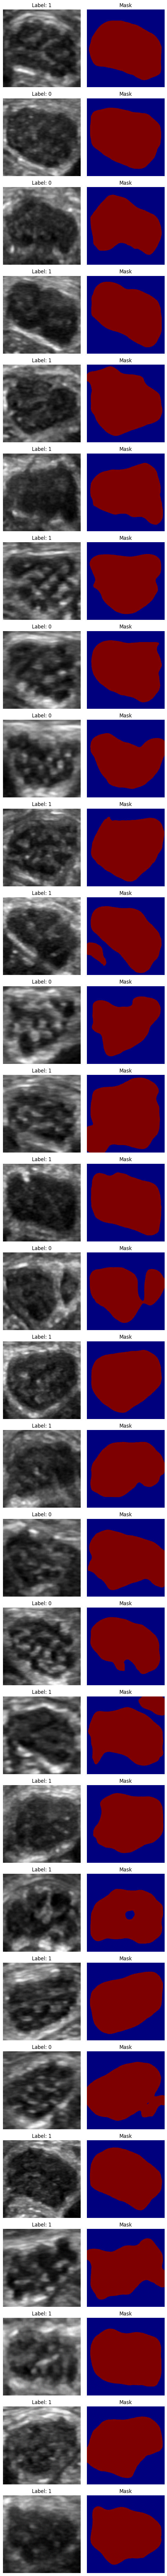

In [147]:
visualize_batch(images, labels)